In [3]:
import sys,os
import numpy as np
lib_path=os.path.abspath("/home/ferrigno/Soft/pysas")
if lib_path not in sys.path:
    sys.path.append(lib_path)
else:
    print("Not appending")
    

import pysas

In [4]:
from astropy.io import fits as pf
def set_rsp_syst(s,r,a,sys):
    f_f  = pf.open(s, 'update')
    f_f[1].header['RESPFILE']=r
    f_f[1].header['ANCRFILE']=a
    f_f[1].data['SYS_ERR']=sys
    f_f.flush()
    f_f.close()

In [43]:

for year in range(2003,2019):
    i_spec_file='Crab_%d_spectrum_osa10.fits'%year
    i_rmf_file='Crab_%d_rmf_osa10.fits.gz'%year
    i_arf_file='Crab_%d_arf_osa10.fits.gz'%year
    
    i_sys=0.015
    
    set_rsp_syst(i_spec_file, i_rmf_file, i_arf_file, i_sys)
    
    j_spec_file='Crab_%d_spectrum_osa10_jemx1.fits'%year
    j_rmf_file='Crab_%d_rmf_osa10_jemx1.fits.gz'%year
    j_arf_file='Crab_%d_arf_osa10_jemx1.fits.gz'%year
    
    j_sys=0.015
    
    set_rsp_syst(j_spec_file, j_rmf_file, j_arf_file, j_sys)
    
    
    
    

2003-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow PhoIndx3
norm  linked or frozen 
Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
PhoIndx1  linked or frozen 
BreakE1  linked or frozen 
PhoIndx2  linked or frozen 
BreakE2  linked or frozen 
PhoIndx3  linked or frozen 
norm  linked or frozen 
2003-2bknpow-chain.fits
Test statistics= 97.12329911830341 Chi2= 97.12329911830341 dof= 55


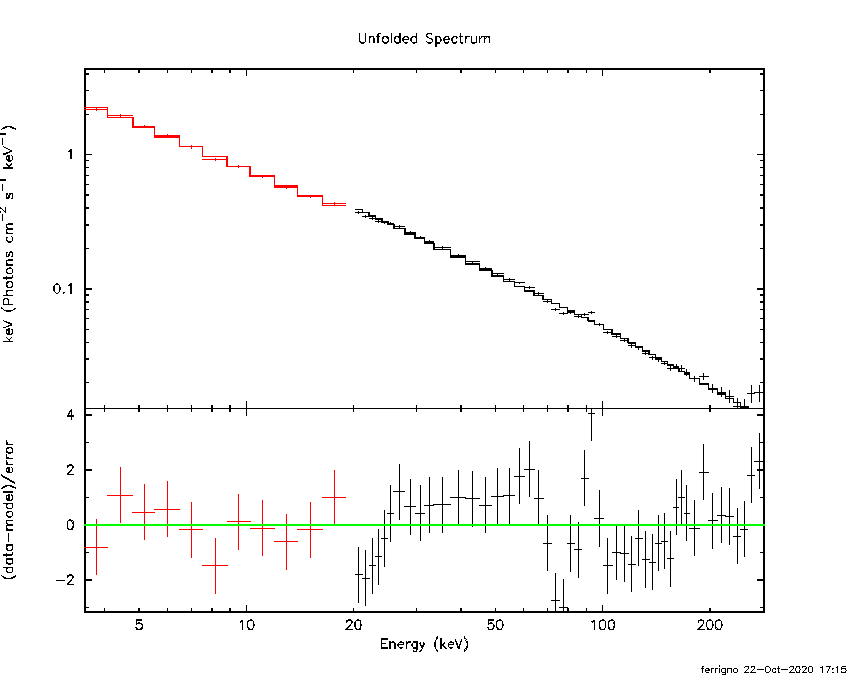

Fit Stat= 97.1232990288308 Chi2= 97.1232990288308 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.09  (2.07-2.12)
	BreakE1 20 keV 
	PhoIndx2__06 2.27  (2.26-2.28)
	BreakE2 100 keV 
	PhoIndx3__08 2.51  (2.47-2.55)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.3  
	BreakE2 100 keV 
	PhoIndx3 2.5  
	norm 1.0  
2004-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow PhoIndx

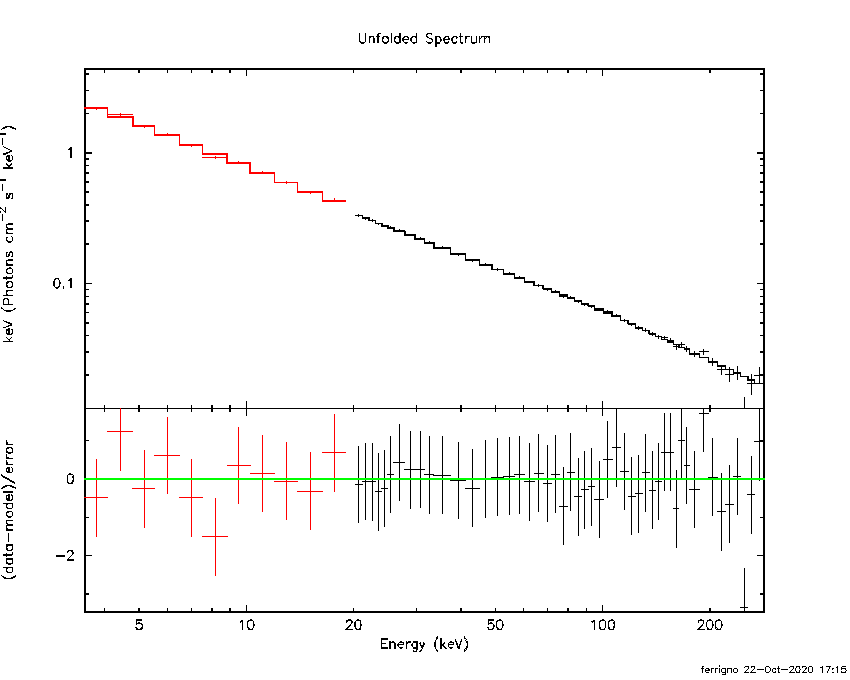

Fit Stat= 27.920055983224994 Chi2= 27.920055983224994 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.08  (2.06-2.10)
	BreakE1 20 keV 
	PhoIndx2__06 2.06  (2.05-2.07)
	BreakE2 100 keV 
	PhoIndx3__08 2.27  (2.24-2.31)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2005-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Pho

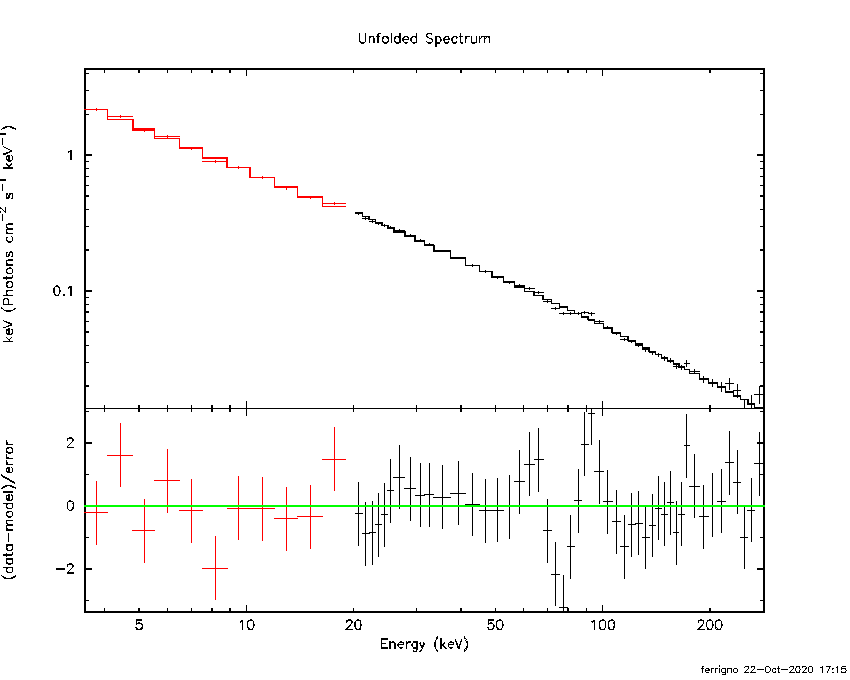

Fit Stat= 64.23085626714044 Chi2= 64.23085626714044 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.07  (2.05-2.09)
	BreakE1 20 keV 
	PhoIndx2__06 2.20  (2.19-2.21)
	BreakE2 100 keV 
	PhoIndx3__08 2.38  (2.35-2.42)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.2  
	BreakE2 100 keV 
	PhoIndx3 2.4  
	norm 1.0  
2006-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow PhoIn

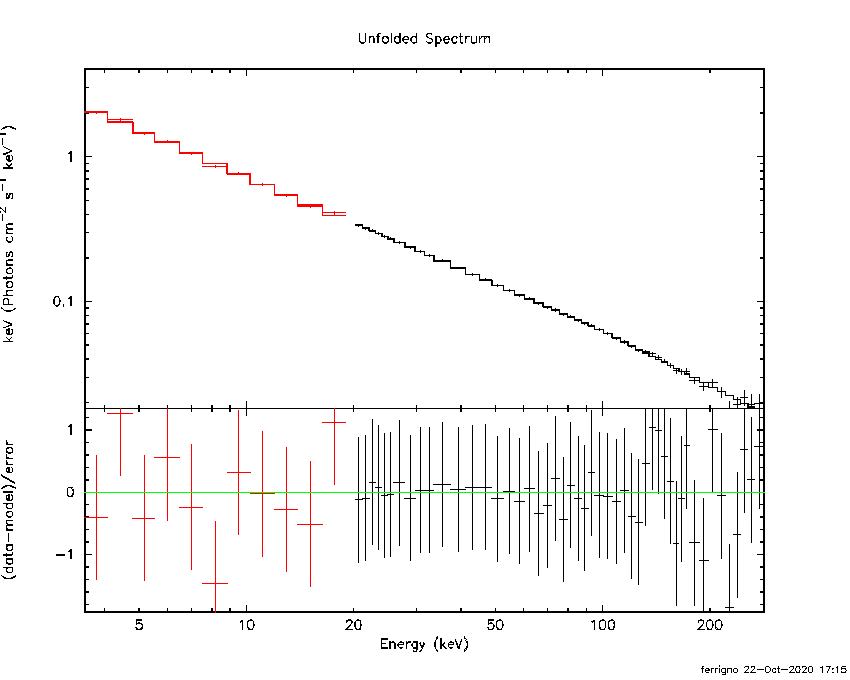

Fit Stat= 18.967266031217 Chi2= 18.967266031217 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.08  (2.05-2.10)
	BreakE1 20 keV 
	PhoIndx2__06 2.07  (2.06-2.08)
	BreakE2 100 keV 
	PhoIndx3__08 2.26  (2.22-2.29)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2007-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow PhoIndx3


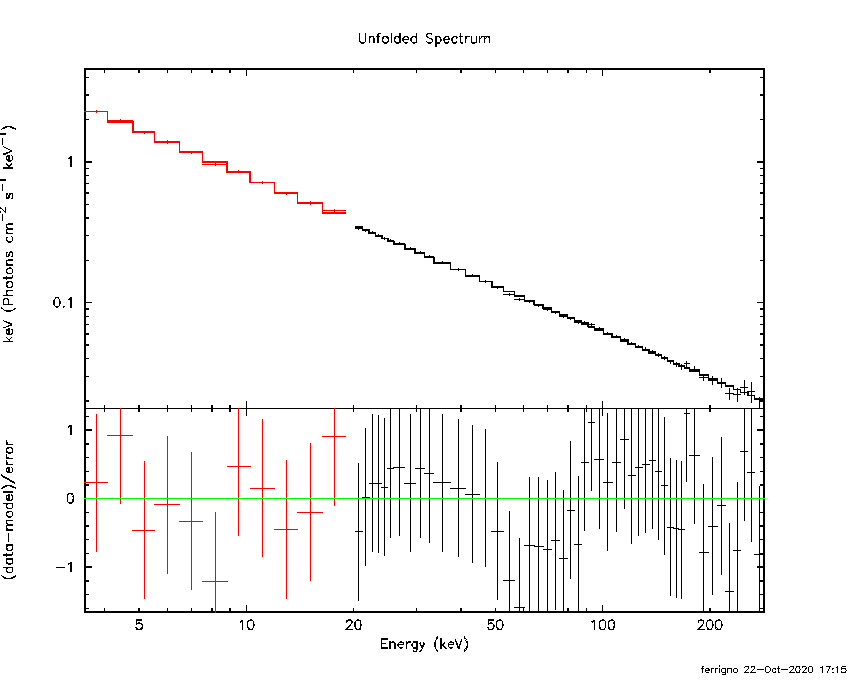

Fit Stat= 23.52104110220468 Chi2= 23.52104110220468 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.08  (2.06-2.10)
	BreakE1 20 keV 
	PhoIndx2__06 2.08  (2.07-2.10)
	BreakE2 100 keV 
	PhoIndx3__08 2.09  (2.05-2.12)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.1  
	norm 1.0  
2008-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow PhoIn

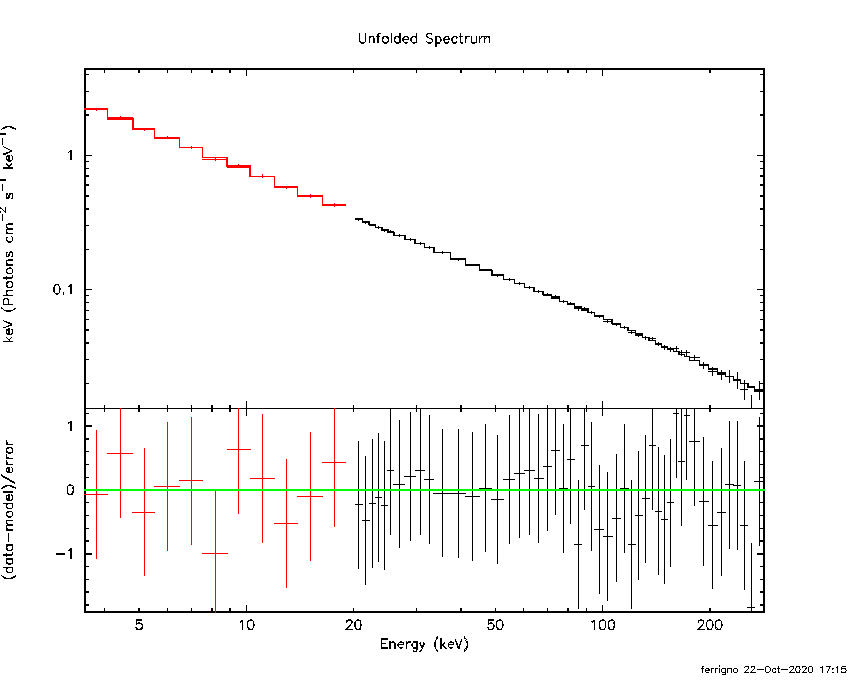

Fit Stat= 15.859112619536633 Chi2= 15.859112619536633 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.08  (2.06-2.10)
	BreakE1 20 keV 
	PhoIndx2__06 2.07  (2.05-2.08)
	BreakE2 100 keV 
	PhoIndx3__08 2.25  (2.21-2.28)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.2  
	norm 1.0  
2009-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Pho

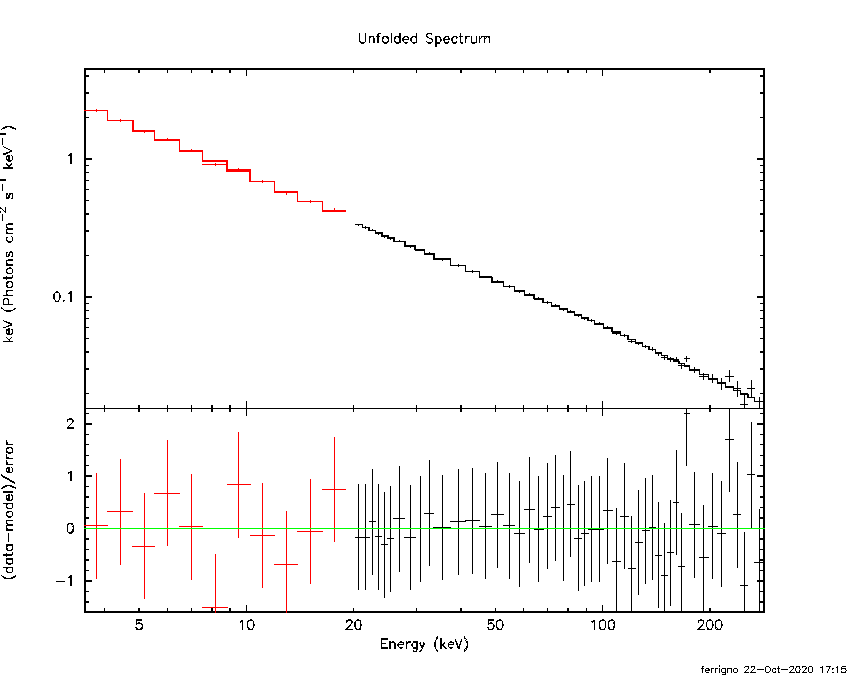

Fit Stat= 19.838515139016714 Chi2= 19.838515139016714 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.10  (2.08-2.12)
	BreakE1 20 keV 
	PhoIndx2__06 2.07  (2.05-2.08)
	BreakE2 100 keV 
	PhoIndx3__08 2.25  (2.22-2.29)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2010-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Pho

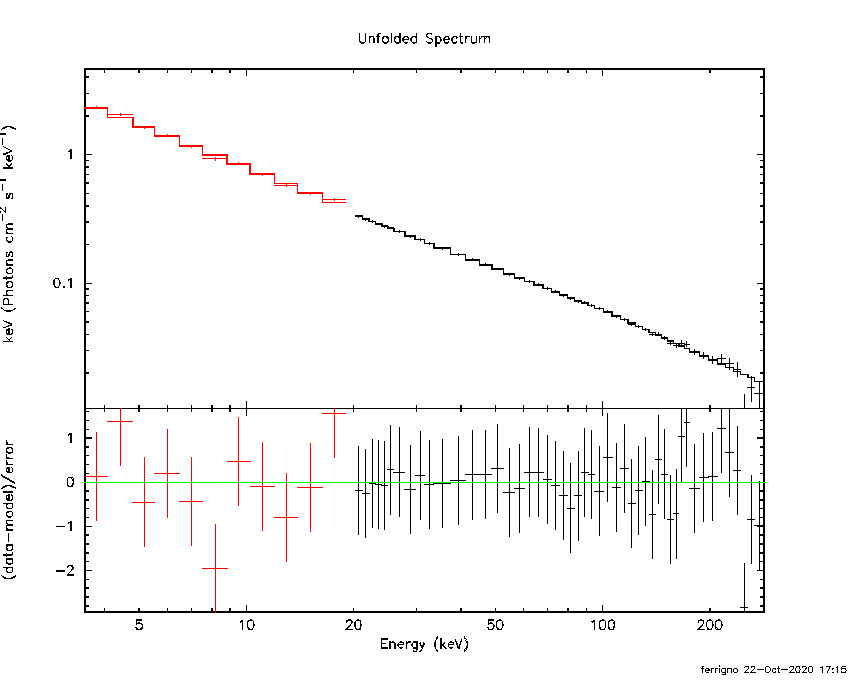

Fit Stat= 28.17032504784426 Chi2= 28.17032504784426 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.10  (2.08-2.13)
	BreakE1 20 keV 
	PhoIndx2__06 2.06  (2.05-2.08)
	BreakE2 100 keV 
	PhoIndx3__08 2.26  (2.23-2.30)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2011-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow PhoIn

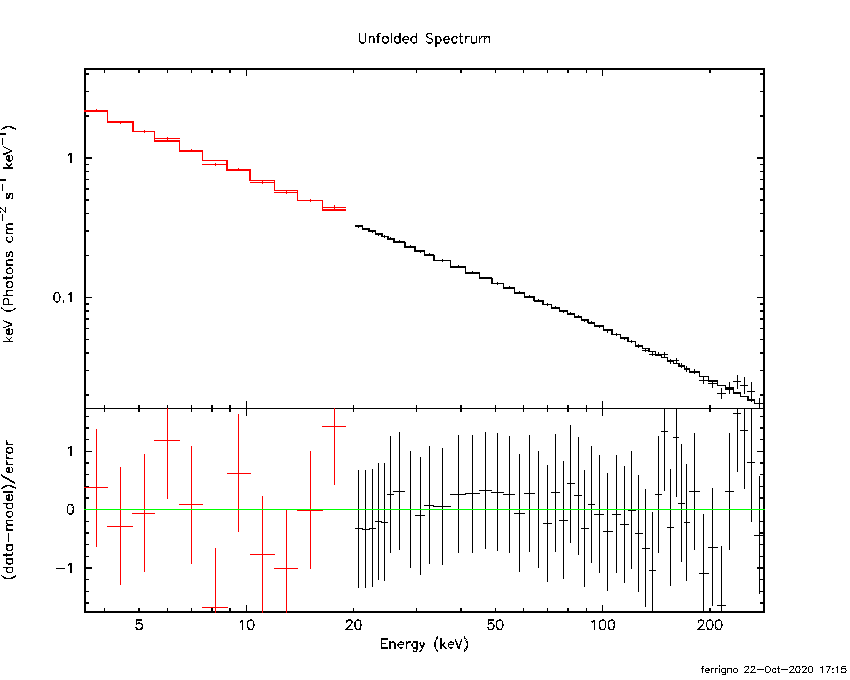

Fit Stat= 25.43036820317223 Chi2= 25.43036820317223 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.06  (2.04-2.08)
	BreakE1 20 keV 
	PhoIndx2__06 2.07  (2.06-2.08)
	BreakE2 100 keV 
	PhoIndx3__08 2.24  (2.21-2.27)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.2  
	norm 1.0  
2012-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow PhoIn

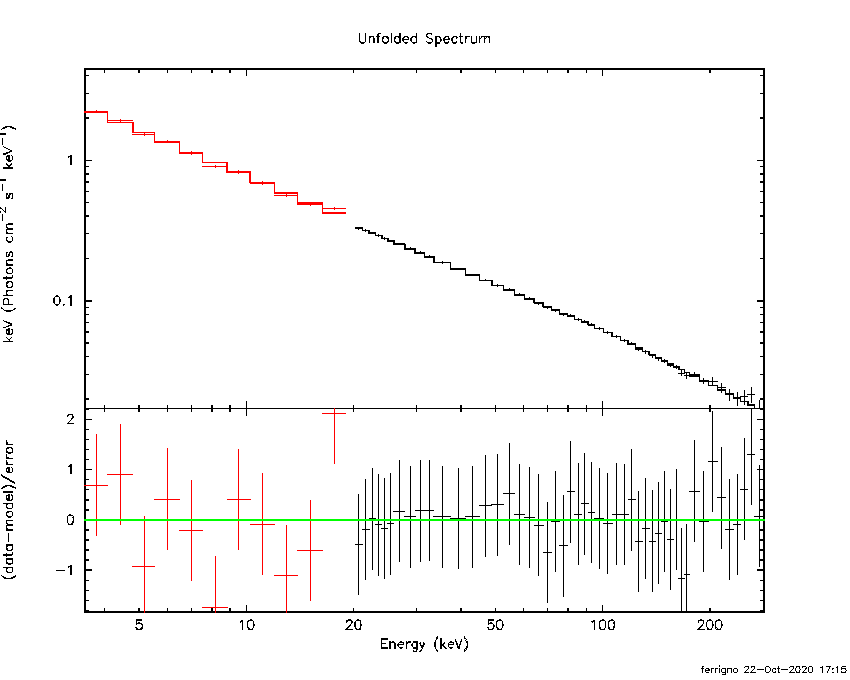

Fit Stat= 21.017395320768017 Chi2= 21.017395320768017 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.07  (2.05-2.09)
	BreakE1 20 keV 
	PhoIndx2__06 2.06  (2.05-2.08)
	BreakE2 100 keV 
	PhoIndx3__08 2.28  (2.25-2.31)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2013-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Pho

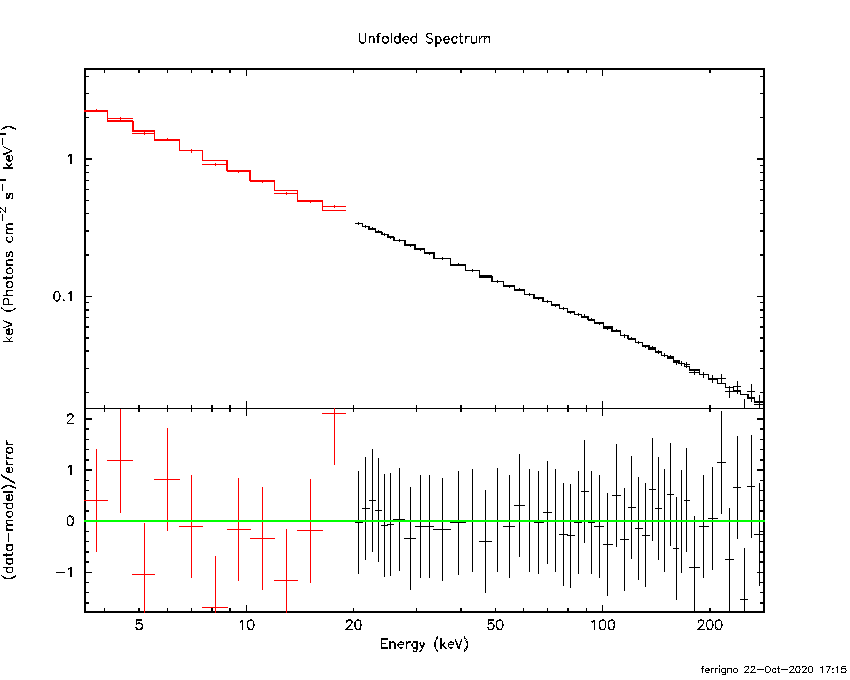

Fit Stat= 21.322668480820127 Chi2= 21.322668480820127 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.09  (2.07-2.11)
	BreakE1 20 keV 
	PhoIndx2__06 2.07  (2.06-2.08)
	BreakE2 100 keV 
	PhoIndx3__08 2.28  (2.25-2.31)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2014-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Pho

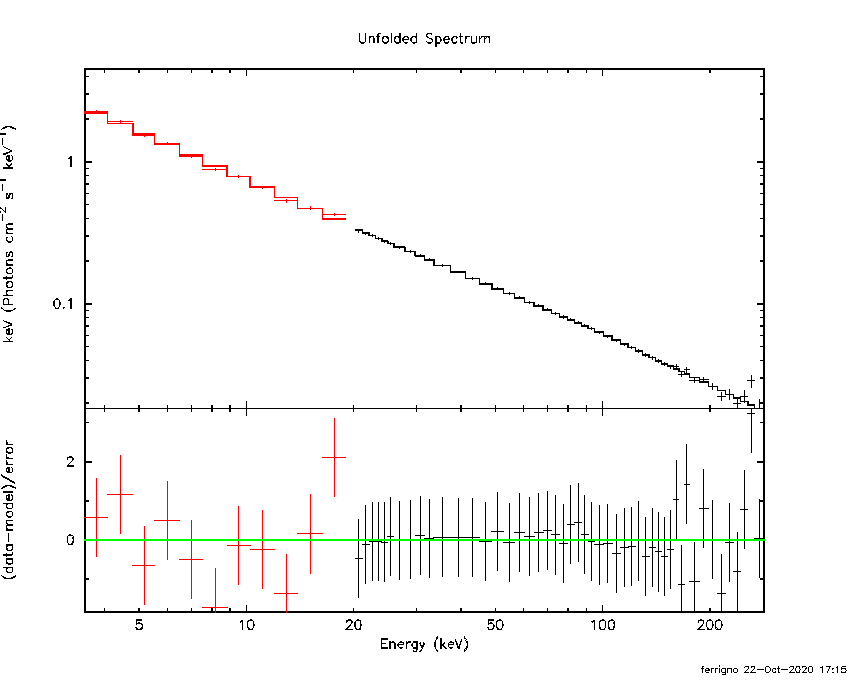

Fit Stat= 33.57266478027752 Chi2= 33.57266478027752 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.12  (2.10-2.14)
	BreakE1 20 keV 
	PhoIndx2__06 2.06  (2.05-2.08)
	BreakE2 100 keV 
	PhoIndx3__08 2.20  (2.17-2.24)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.2  
	norm 1.0  
2015-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow PhoIn

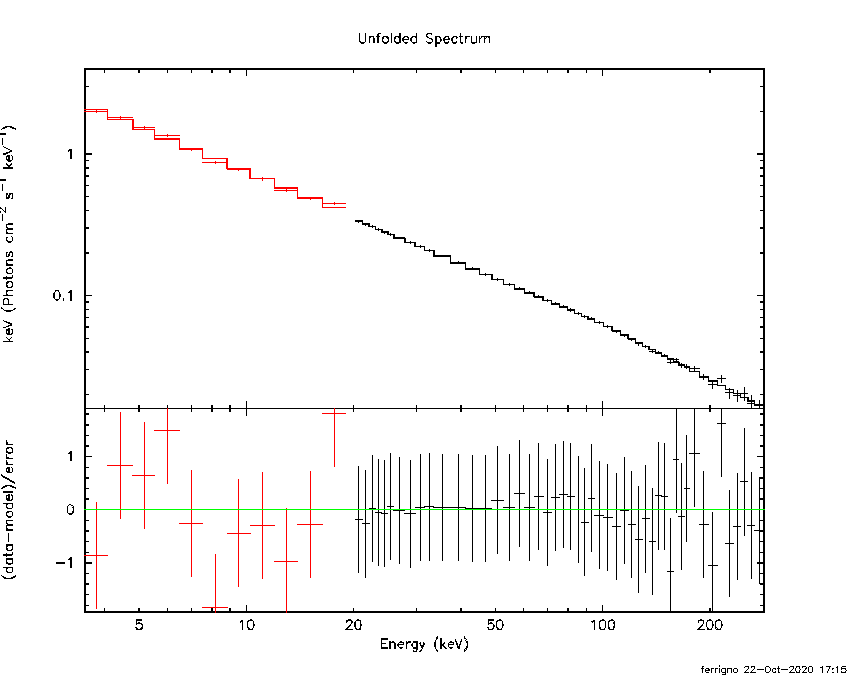

Fit Stat= 22.177238862424847 Chi2= 22.177238862424847 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.04  (2.02-2.06)
	BreakE1 20 keV 
	PhoIndx2__06 2.06  (2.05-2.07)
	BreakE2 100 keV 
	PhoIndx3__08 2.30  (2.27-2.33)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.0  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2016-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Pho

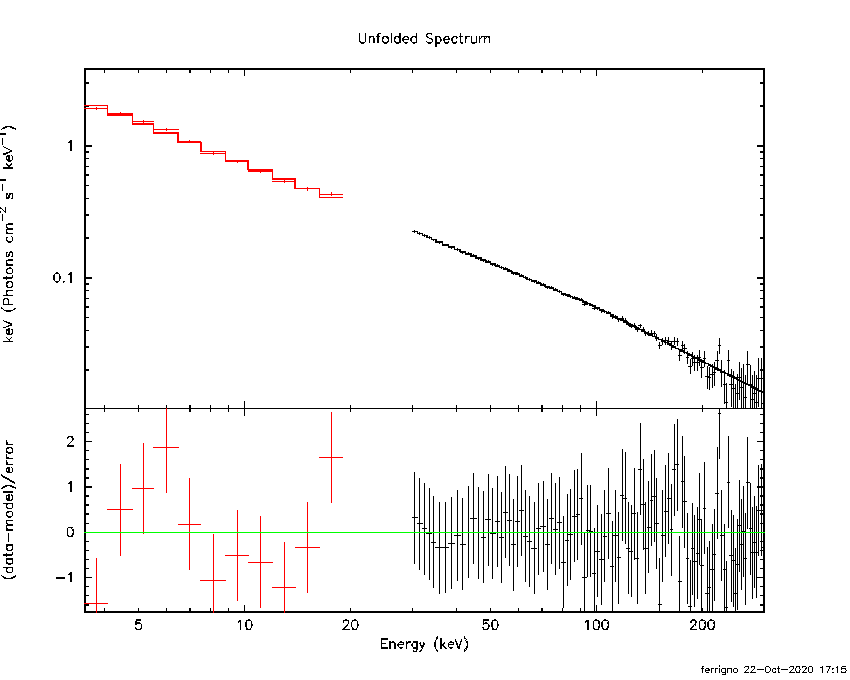

Fit Stat= 62.61595374030752 Chi2= 62.61595374030752 dof= 112

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.04  (2.02-2.07)
	BreakE1 20 keV 
	PhoIndx2__06 2.11  (2.09-2.12)
	BreakE2 100 keV 
	PhoIndx3__08 2.36  (2.33-2.40)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.0  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.4  
	norm 1.0  
2017-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow PhoI

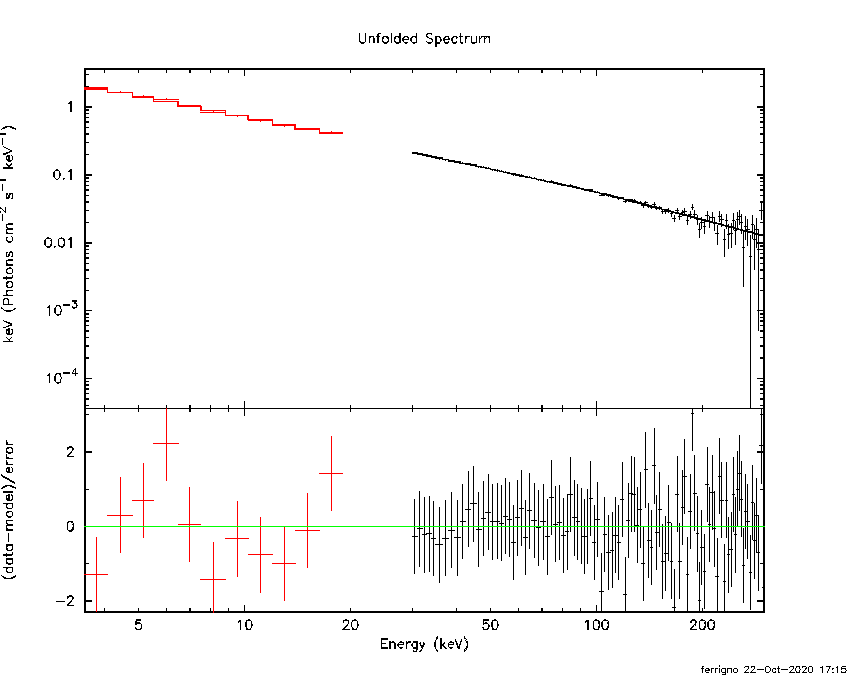

Fit Stat= 88.11024281945659 Chi2= 88.11024281945659 dof= 112

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.01  (1.99-2.03)
	BreakE1 20 keV 
	PhoIndx2__06 2.11  (2.10-2.13)
	BreakE2 100 keV 
	PhoIndx3__08 2.35  (2.32-2.39)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.0  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.4  
	norm 1.0  
2018-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow PhoI

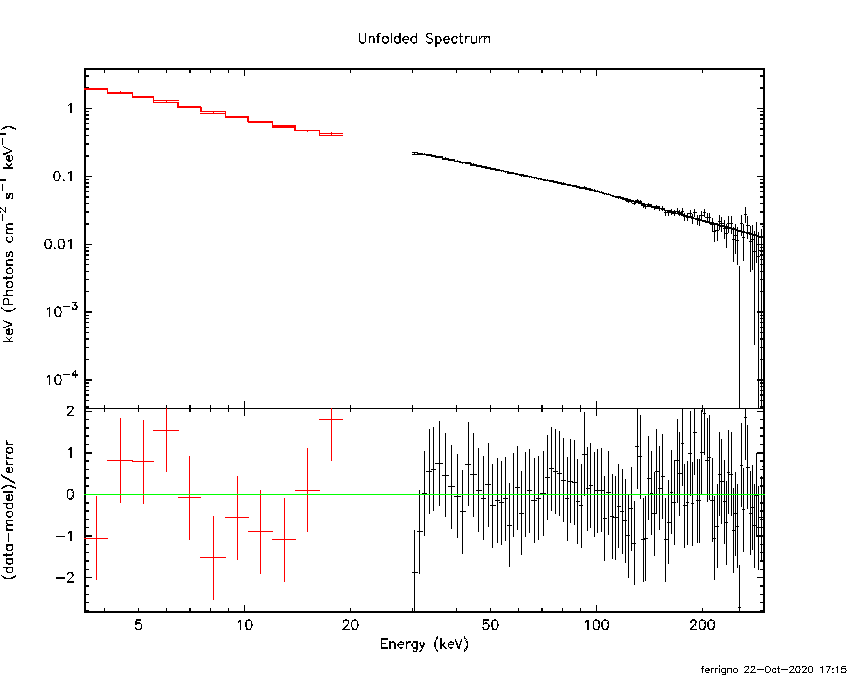

Fit Stat= 64.78888906399901 Chi2= 64.78888906399901 dof= 112

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.04  (2.02-2.06)
	BreakE1 20 keV 
	PhoIndx2__06 2.10  (2.09-2.12)
	BreakE2 100 keV 
	PhoIndx3__08 2.44  (2.41-2.48)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.0  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.4  
	norm 1.0  


In [44]:
import xspec
verbose=True
mod_file='mod_2bknpow.xcm'
verbose=True
ignore_string=['**-20.0, 300.0-**', '**-3.5,20.0-**']

chains=[]
fit_by_bin={}

for year in range(2003,2019):

    isgri_spec='Crab_%d_spectrum_osa10.fits'%year
    jemx1_spec='Crab_%d_spectrum_osa10_jemx1.fits'%year
    outputfiles_basename='%d'%year+'-'+mod_file.replace('mod_','').replace('.xcm','')+"-"
    print(outputfiles_basename)
    run_chain=False
    load_chain=False
    perform_fit=True
    
    chain_name, fit_res =pysas.epic_xspec_mcmc_fit(xspec, mod_file, 
                                outputfiles_basename = outputfiles_basename,
                                pn_spec = isgri_spec,
                                mos1_spec = jemx1_spec,
                                mos2_spec = 'none', 
                                jeffreys_priors=[],
                                ignore_string=ignore_string,
                                load_chain=load_chain, perform_fit=True, set_priors=True, walkers=40, 
                                               run_chain=run_chain,
                                               compute_errors=True, save_xcm=True, statistics='chi' )
    chains.append(chain_name)
    
    #exposure, tstart, tstop = pysas.get_spec_exp_times(ss)
    
    #print(tstart, tstop)
    
    exposure, tstart, tstop = pysas.get_spec_exp_times(isgri_spec)
    fit_res.update( {'times': [tstart,tstop] } )
        
    fit_by_bin.update({outputfiles_basename : fit_res})

In [45]:
fit_by_bin

{'2003-2bknpow-': {'rate': [298.1610051319003,
   297.2124839141049,
   299.1095263496957],
  'cstat': [97.1232990288308, 55],
  'plot_filename': '2003-2bknpow-euf_plot.png',
  'lg10Flux__03': [-7.768158450076484, -7.770961680821738, -7.765331430026467],
  'PhoIndx1__04': [2.0935059129378875, 2.071856240495971, 2.1151720348136016],
  'PhoIndx2__06': [2.2729208644848824, 2.260947926880791, 2.284901377813754],
  'PhoIndx3__08': [2.5086987478148397, 2.4726325347989806, 2.5454091186536463],
  'lg10Flux__12': [-7.764432337482836, -7.769371319457511, -7.759427752094538],
  'times': [1322.34221033679, 1323.03131947371]},
 '2004-2bknpow-': {'rate': [300.13404186815023,
   299.1856460877483,
   301.0824376485522],
  'cstat': [27.920055983224994, 55],
  'plot_filename': '2004-2bknpow-euf_plot.png',
  'lg10Flux__03': [-7.772351561273943, -7.77509288217545, -7.7695892350249816],
  'PhoIndx1__04': [2.0807985116302343, 2.0591547108179533, 2.102461719661796],
  'PhoIndx2__06': [2.0616459953202577, 2.

In [48]:
latex_label_dict = {
    'cstat' : '$\\chi^2_\\mathrm{red}$',
    'lg10Flux__03' : '$\\log(F_\\mathrm{20-100keV})$',
    'lg10Flux__12' : '$\\log(F_\\mathrm{5-20keV})$',
    'PhoIndx1__04' : '$\\Gamma_1$',
    'PhoIndx2__06' : '$\\Gamma_2$',
    'PhoIndx3__08' : '$\\Gamma_3$'
}

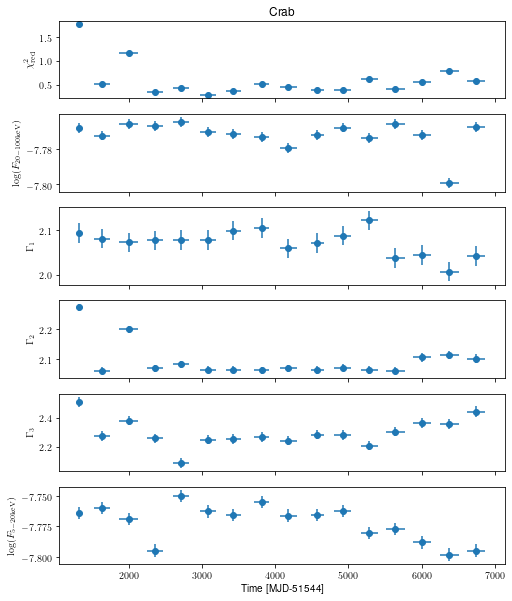

In [49]:
pysas.plot_fit_parameters_norate(fit_by_bin, plot_latex=True, latex_label_dict=latex_label_dict,
                               skipped=['factor', 'plot_filename'], save_plot=True,
                               xlabel='Time [MJD-51544]', title='Crab', log_scale_labels=[])